In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt

from gan_lab import get_current_configuration
from gan_lab.utils.latent_utils import gen_rand_latent_vars
from gan_lab.utils.data_utils import prepare_dataset, prepare_dataloader
from gan_lab.stylegan.learner import StyleGANLearner

In [2]:
MODEL_PATH = '../gan_lab/models/stylegan_model.tar'

STYLEMIXING_SAVE_PATH = './stylemixing_grid.png'
IMAGEGRID_SAVE_PATH = './image_grid.png'
IMAGE_SAVE_PATH = './image.png'

DEV = 'cpu'
USE_EWMA_MODEL = True

In [3]:
config = get_current_configuration( 'config' )
# data_config = get_current_configuration( 'data_config' )

In [4]:
learner = StyleGANLearner( config )

-------- Initialized Model Configuration --------
  ac_disc_scale: 1.0
  ac_gen_scale: 0.1
  align_corners: False
  batch_size: 8
  beta1: 0.0
  beta2: 0.99
  beta_trunc_trick: 0.995
  bit_exact_resampling: False
  blur_type: binomial
  bs_dict: {4: 8, 8: 8, 16: 8, 32: 8, 64: 8, 128: 8, 256: 8, 512: 4, 1024: 2}
  class_condition: False
  cutoff_trunc_trick: 4
  dev: cuda
  disc_metrics: ['discriminator loss', 'fake realness', 'real realness']
  enable_cudnn_autotuner: True
  eps: 1e-08
  eps_drift: 0.001
  gamma: 1.0
  gen_bs_mult: 1
  gen_metrics: ['generator loss', 'fake realness', 'image grid']
  gradient_penalty: r1
  img_grid_show_labels: True
  img_grid_sz: 4
  init_res: 8
  latent_distribution: normal
  lda: 10.0
  leakiness: 0.2
  len_dlatent: 512
  len_latent: 512
  loss: nonsaturating
  lr_base: 0.001
  lr_fctr_dict: {4: 1.0, 8: 1.0, 16: 1.0, 32: 1.0, 64: 1.0, 128: 1.5, 256: 2.0, 512: 3.0, 1024: 3.0}
  lr_sched: resolution dependent
  lr_sched_custom: None
  mapping_lrmul: 0.

In [5]:
learner.load_model( MODEL_PATH )

/home/sid/anaconda3/envs/py37torch/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.upsampling.Upsample' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/sid/anaconda3/envs/py37torch/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.AvgPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/sid/anaconda3/envs/py37torch/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.activation.LeakyReLU' has changed. you can re

---------- Loaded Model Configuration -----------
  model: StyleGAN
  dev: cuda
  n_gpu: 1
  enable_cudnn_autotuner: True
  random_seed: -1
  gen_bs_mult: 1
  num_gen_iters: 1
  loss: nonsaturating
  gradient_penalty: r1
  lda: 10.0
  gamma: 1.0
  lr_sched_custom: None
  optimizer: adam
  beta1: 0.0
  eps: 1e-08
  wd: 0.0
  align_corners: False
  model_upsample_type: nearest
  model_downsample_type: average
  latent_distribution: normal
  num_classes: 0
  class_condition: False
  use_auxiliary_classifier: False
  ac_disc_scale: 1.0
  ac_gen_scale: 0.1
  num_iters_valid: 1000
  metrics_dev: cpu
  gen_metrics: ['generator loss', 'fake realness', 'image grid']
  disc_metrics: ['discriminator loss', 'fake realness', 'real realness']
  img_grid_sz: 4
  img_grid_show_labels: True
  save_samples_dir: /home/sid/repos/ml-repos/gan-lab/gan_lab/samples
  num_iters_save_model: 1000
  save_model_dir: /home/sid/repos/ml-repos/gan-lab/gan_lab/models
  num_workers: 12
  pin_memory: True
  batch_size: 

In [6]:
if DEV not in ( 'cpu', torch.device( 'cpu' ), ): learner.gen_model.to( DEV )
learner.gen_model.eval()
# learner.disc_model.to( DEV )
# learner.disc_model.eval()
if USE_EWMA_MODEL:
  if DEV not in ( 'cpu', torch.device( 'cpu' ), ): learner.gen_model_lagged.to( DEV )
  learner.gen_model_lagged.eval()

In [7]:
# learner.gen_model.__class__.__name__, learner.disc_model.__class__.__name__

In [8]:
# learner.config.len_latent, learner.latent_distribution, learner.gen_model.gen_layers[3][3].linear.weight.device

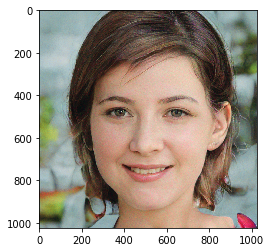

In [9]:
# === SINGLE IMAGE

z = gen_rand_latent_vars( num_samples = 1, length = learner.config.len_latent,
                          distribution = learner.latent_distribution, device = DEV )

# fig = plt.figure( figsize=(16,16,))
# ax = fig.add_subplot(1,1,1)
# ax.imshow(  np.clip(
#             ( learner.gen_model_lagged( z ).squeeze().detach().cpu() * learner.ds_std + learner.ds_mean ) \
#                 .numpy().transpose( 1, 2, 0 ), 0, 1 ), interpolation = 'none'
#              )
# fig.savefig( IMAGE_SAVE_PATH, dpi = learner.gen_model.curr_res/fig.get_figheight() )

learner.plot_sample( z, time_average = USE_EWMA_MODEL )

plt.imsave( IMAGE_SAVE_PATH, np.clip(
            ( learner.gen_model_lagged( z ).squeeze().detach().cpu() * learner.ds_std + learner.ds_mean ) \
                .numpy().transpose( 1, 2, 0 ), 0, 1 ), )

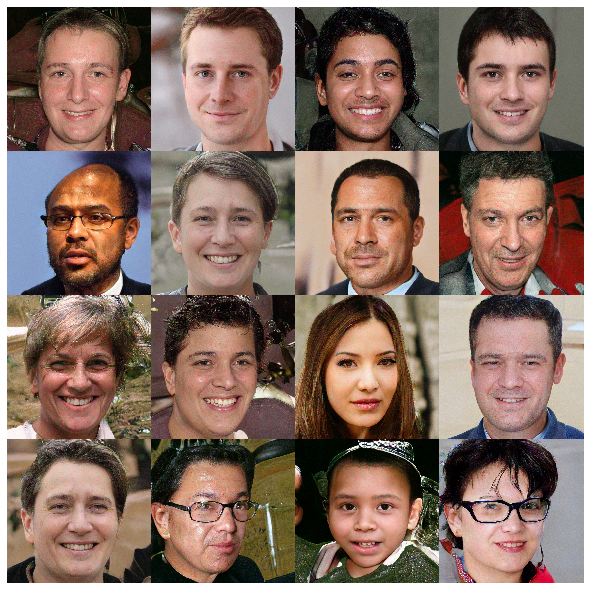

In [10]:
# === IMAGE GRID

zs = gen_rand_latent_vars( num_samples = 16, length = learner.config.len_latent,
                           distribution = learner.latent_distribution, device = DEV )

fig, ax = learner.make_image_grid( zs, time_average = USE_EWMA_MODEL, save_path = IMAGEGRID_SAVE_PATH )

# fig.show()

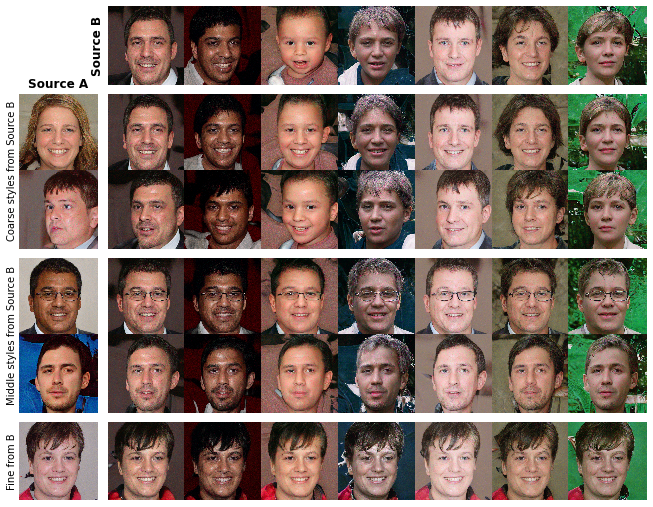

In [11]:
# === STYLEMIXING GRID

zs_sourceb = gen_rand_latent_vars( num_samples = 7, length = learner.config.len_latent,
                                   distribution = learner.latent_distribution, device = DEV )

zs_coarse = gen_rand_latent_vars( num_samples = 2, length = learner.config.len_latent,
                                  distribution = learner.latent_distribution, device = DEV )
zs_midle =  gen_rand_latent_vars( num_samples = 2, length = learner.config.len_latent,
                                  distribution = learner.latent_distribution, device = DEV )
zs_fine =   gen_rand_latent_vars( num_samples = 1, length = learner.config.len_latent,
                                  distribution = learner.latent_distribution, device = DEV )

fig, ax = learner.make_stylemixing_grid( zs_sourceb, zs_coarse, zs_midle, zs_fine,
                                         time_average = USE_EWMA_MODEL, save_path = STYLEMIXING_SAVE_PATH )

# fig.show()